# **Pokémon Diffusion<a id="top"></a>**

> #### ``02-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 18/03/2024</small></i></div>

Como bien se ha descrito antes, el modelo de difusión es un modelo generativo que se basa en la difusión de ruido en una imagen para generar muestras. Este modelo se puede dividir en dos etapas: difusión hacia adelante ***(Forward Diffusion)*** y difusión inversa ***(Inverse Diffusion)***. Cada una de estas dos partes, simboliza los dos pasos del modelo de difusión: añadir ruido a la imagen de entrada y eliminar el ruido de la imagen resultante. 

Todo ello siguiendo una ***cadena de Markov***, donde el proceso de **forward diffusion** se puede describir como: $p(x_{t} | x_{t-1})$, la distribución de probabilidad de la imagen en el paso de tiempo $t$ dado el paso de tiempo anterior $t-1$. De modo que la imagen en el paso de tiempo $t$ depende solo de la imagen en el paso de tiempo anterior $t-1$. Y el **inverse diffusion** $q_{\theta}(x_{t-1} | x_{t})$ es la distribución de probabilidad inversa, es decir, la distribución de probabilidad de la imagen en el paso de tiempo $t-1$ dado el paso de tiempo $t$ y de igual manera, la imagen en el paso de tiempo $t-1$ depende solo de la imagen en el paso de tiempo $t$.

<p align="center">
    <img src='https://miro.medium.com/v2/resize:fit:1280/1*eMQRwGrq4o8UoXoIBjTDoA.png' width=40% height=50% />
</p>

En cada sección, se explicará el funcionamiento de cada una de las partes del modelo de difusión. Primero, empezaremos definiendo los hiperparámetros del modelo de difusión. Estos hiperparámetros son los que se han usado en los papers [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) y [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672) y se han mantenido para este proyecto.

- ``T``: Número de pasos de difusión, es decir, el número de veces que se añade ruido a la imagen de entrada.

- ``beta_start`` y ``beta_end``: Parámetros que determinan la cantidad de ruido que se añade en cada paso. Un valor más alto de *beta* significa que se añade más ruido, y, por tanto, una mayor diversidad en las muestras generadas, pero también implica una mayor dificultad para el modelo de difusión. *beta_start* es el valor de *beta* en el primer paso y *beta_end* es el valor de *beta* en el último paso. Más adelante se explicará este concepto con más detalle.

- ``s``: el factor de escala de la distribución de ruido. Es decir, determina el desplazamiento aplicado al paso de tiempo "t" durante el proceso de añadir ruido a la imagen. Este desplazamiento modifica la fase de la función coseno, influyendo en la progresión de la varianza desde los pasos de tiempo iniciales hasta los finales, afectando así la suavidad de la transición en los niveles de ruido aplicados durante el proceso de difusión.

A continuación, haremos uso de la función ``create_dataset()`` definida con anterioridad para crear el dataset de entrenamiento del modelo de difusión y aplicar todo el proceso de preprocesado de datos explicado anteriormente.

---

<span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Se ha optado por darle unos valores bajos de beta ya que en este notebook haremos uso de *schedule* ``cosine``. Más adelante explicaremos este concepto.
</small></i>

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)

    - [1.1. Carga de datos](#-1.1.-Carga-de-datos)
    - [1.2. Creación del dataset](#-1.2.-Creación-del-dataset)

- [2. Forward Diffusion](#-2.-Forward-Diffusion)

- [3. Inverse Diffusion](#-3.-Inverse-Diffusion)

# 0. Imports

Una vez introducido el proyecto, se importan las librerías necesarias para el desarrollo de este apartado.

---

In [12]:
# Import necessary libraries
# =====================================================================
import re
import numpy as np
from matplotlib import pyplot as plt

# Import libraries for data preprocessing
import configparser
import pandas as pd
import random

import tensorflow as tf

# Import src code
from src.data import path_loader as pl
from src.data import create_dataset
from src.visualization import visualize
from src.models import forward_diffusion as fd

In [13]:
# Set config file
# =====================================================================
SETTINGS_PATH = "../config.ini"
config = configparser.ConfigParser()
config.read(SETTINGS_PATH)

config_paths = config["paths"]
data_path = config_paths["data_path"]

# 1. Dataset

En primer lugar se cargarán los datos necesarios para la creación del dataset de entrenamiento del modelo de difusión. Por ello, se cargará el csv ya limpio y los paths de imágenes con el objetivo de crear dicho dataset haciendo uso de la función ``create_datatset()`` definida en el notebook anterior, aplicando todo el proceso de preprocesado de datos explicado previamente.

## 1.1. Carga de datos

In [14]:
# Load csv file
# =====================================================================
df = pd.read_csv(f"{data_path}/processed/pokedex_cleaned.csv")

df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


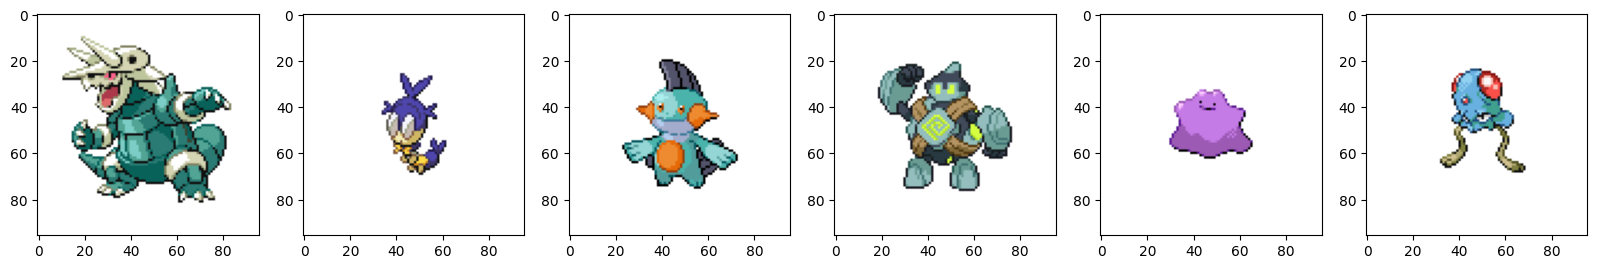

In [15]:
# Load data paths
# =====================================================================
image_paths = pl.get_image_paths(f"{data_path}/interim/image_paths.json")

visualize.plot_image_paths(image_paths)

## 1.2. Creación del dataset

In [17]:
# Hyperparameters
# =====================================================================
T = 1000  # number of diffusion steps
beta_start = 1e-4  # initial value of beta
beta_end = 0.02  # final value of beta
s = 0.008  # scale factor for the variance curve

IMG_SIZE = 64
BATCH_SIZE = 32

# Create the dataset
# =====================================================================
# poke_dataset = create_dataset.dataset_tf(
#     image_paths=image_paths,
#     df=df,
#     img_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     save=True,
#     save_path=f"{data_path}/processed/pokemon_tf_dataset",
# )  # remember that you can also give the data_dict as input instead of the image_paths and df

poke_dataset = tf.data.Dataset.load(
    path=f"{data_path}/processed/pokemon_tf_dataset", compression="GZIP"
)

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-03-18 20:52:35.931909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


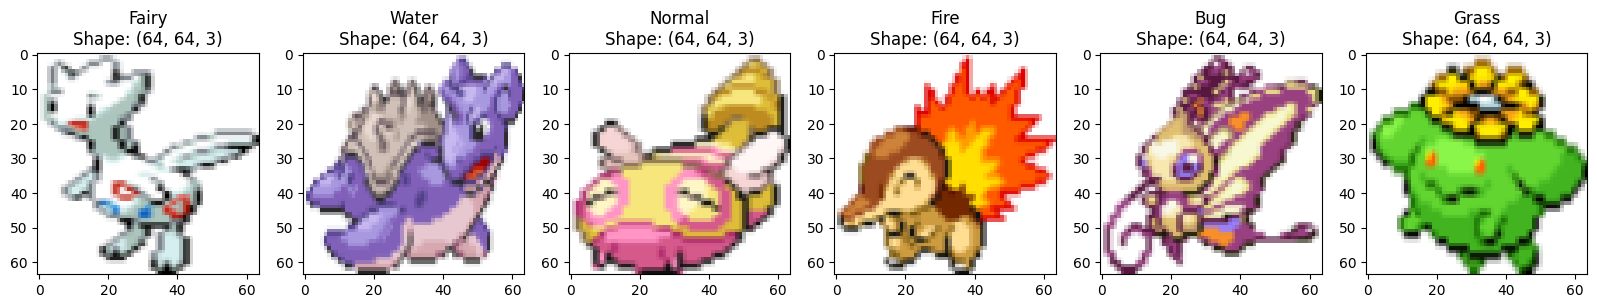

2024-03-18 20:52:37.700290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(poke_dataset, df, 6)

## Forward Diffusion

El proceso de **forward diffusion** se basa en añadir iterativamente ruido a la imagen
de entrada hasta conseguir ruido puro que siga una distribución gaussiana $\mathcal{N}(0, I)$, donde $I$ es la matriz identidad. Este proceso se realiza en $T$ pasos, donde en cada paso se añade una cantidad de ruido determinada por el parámetro $\beta$ a través de un **variance scheduler** que no es más  que la secuencia de $\beta$ que describe la manera en la que se añade ruido a la imagen de entrada dependiendo del instante de tiempo en el que se encuentre hasta llegar a $T$.

<p align="center">
    <img src='https://cdn.hashnode.com/res/hashnode/image/upload/v1677937815866/f9b6be3d-83e5-4749-823f-dbc9a5c98d78.jpeg?auto=compress,format&format=webp' width=50% height=50% />
</p>

Cada instante $t+1$ es generado a partir del instante $t$ añadiendo ruido gaussiano a la imagen. Con esto, se consigue cambiar la distribución de datos de los ejemplos del dataset a una gaussiana. Cada eslabón de la cadena de Markov de nuestro modelo corresponde a una distribución distinta. Es decir, la distribución de ruido es una distribución gaussiana con media 0 y varianza $\beta_{t}$, este valor de $\beta_{t}$ es el **diffusion rate** que se calcula para cada instante de tiempo *t* a partir dependiendo del **schedule** que se use, como ya se menciono con anterioridad. 

Por tanto, la distribución de probabilidad de la imagen en el paso de tiempo $t$ dado el paso de tiempo anterior $t-1$ se puede expresar como:

$$p(x_{t} | x_{t-1}) = \mathcal{N}(x_{t} | \sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}I)$$

Esta fórmula se puede simplificar a través del truco de reparametrización, el renombramiento de $\beta_{t}$ como $\alpha_{t} = 1 - \beta_{t}$ y $\bar{\alpha}_{t} = \prod_{i=1}^{t} \alpha_{i}$ y por recursividad, podemos reescribir la anterior expresión como:

$$x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1 - \bar{\alpha}_{t}}\epsilon_{t}$$

Con este proceso conseguiremos obtener una imagen en cualquier instante de tiempo $t ,,0 <= t <= T$ de la difusión, para posteriormente poder realizar el proceso inverso.

Para lograr esto, se han definido varias funciones. La función principal, ``forward_diffusion()`` se encarga de realizar la difusión hacia adelante implementando lo comentado con anterioridad. Para ello, primero define el valor $\beta$ a través de ``beta_schedule()``. Esta función se encarga de calcular el valor de $\beta$ en cada paso de difusión. Tenemos dos opciones para calcular el valor de $\beta$:
- ``linear`` que añade ruido de manera lineal.
- ``cosine`` que añade ruido de manera más suave al principio y más abrupta en el medio.
   
En este caso, se ha optado por usar ``cosine`` ya según el paper original, se obtienen mejores resultados. Esto se debe a que la función coseno es más suave que la lineal, por lo que la transición entre los niveles de ruido aplicados en cada paso de difusión es más suave. Esto permite que el modelo de difusión aprenda de manera más eficiente y estable, y, por tanto, genere muestras de mayor calidad, pues a partir de algo más de la mitad de los pasos, niveles de ruido usando ``linear`` son muy altos, es decir ya son imágenes muy ruidosas, y esto hace que el modelo de difusión tenga más dificultad para aprender, pues son redundantes y destruye la información de la imagen original muy rápido.

Para calcular el scheduler del coseno, se usa la siguiente fórmula:

$$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos \left( \frac{t/T + s}{1 + s} \cdot \frac{\pi}{2} \right)^2,  \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}.
$$

En la práctica, limitamos a **$\beta$** para que no sea mayor que 0.999 para prevenir singularidades al final del proceso de difusión cerca de $t = T$.

Una vez definido el valor de **$\beta$**, se procede a calcular el valor acumulado de **$\alpha$** en cada paso de difusión y a generar el ruido que se añadirá a la imagen de entrada. Finalmente, se devuelve la imagen de entrada con el ruido añadido. Esto se hace siguiendo la fórmula anteriormente comentada, que nos permite calcular una imagen en un instante de tiempo *t* cualquiera a partir de la imagen original sin necesidad de iterar todo el rato hasta llegar a ese instante de tiempo, lo cual hace que nos ahorremos mucho tiempo de entrenamiento. ($x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1 - \bar{\alpha}_{t}}\epsilon_{t}$)

---

<i><small>**Más información** sobre como se consigue esta fórmula en el artículo [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

<span style="color: red; font-size: 1.5em;">&#9888;</span> **NOTA:** El proceso matemático para llegar a esta fórmula es muy complejo para explicarlo en este notebook. Sin embargo, en el futuro informe se explicará con más detalle. </small></i>

Para ayudar a visualizar este proceso de difusión directa, usaremos:
- ``plot_noise_levels()`` mustra una gráfica donde se ve como se va añadiendo ruido hasta obtner un ruido total. 
- ``plot_forward_diffusion()`` muestra dicho proceso gráficado pero con un imagen en distintos intasntes de tiempo. 

Esto se hace tanto como para ``linear`` como para ``cosine``. Todo ello, con el objetivo de ilustrar la justificación del uso de ``cosine``.

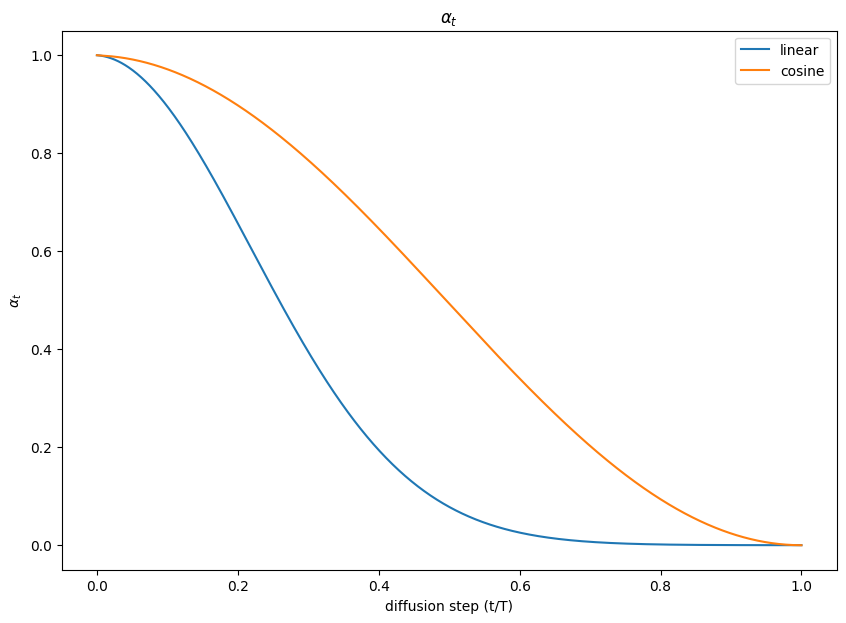

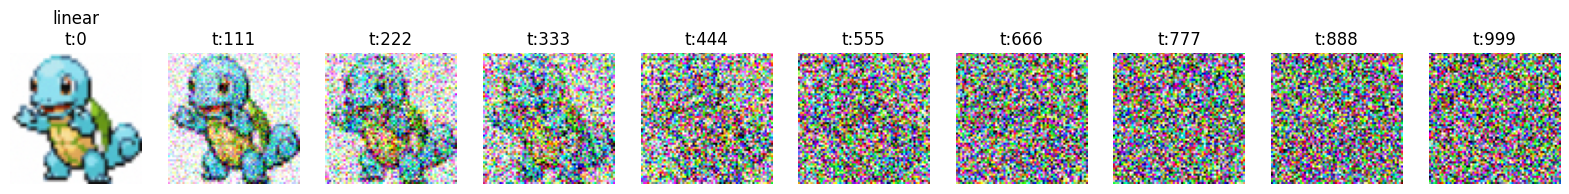

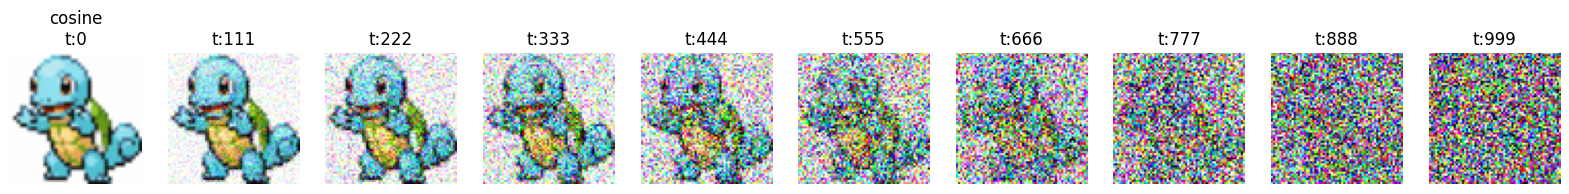

In [10]:
# Plot all the noise levels in the same plot
# =====================================================================
visualize.plot_noise_levels(T, beta_start, beta_end, s)

# Plot the forward diffusion function
# =====================================================================
X_train = poke_dataset.map(lambda x, y: x)  # Get the images from the dataset
random_image = next(iter(X_train))[random.randint(0, BATCH_SIZE)]

visualize.plot_forward_diffusion(random_image, "linear", 10, T, beta_start, beta_end, s)
visualize.plot_forward_diffusion(random_image, "cosine", 10, T, beta_start, beta_end, s)

Como hemos dicho anteriormente, uno de los hiperparámetros más importantes del modelo de difusión es el ``scheduler``. Este hiperparámetro determina la forma en la que se añade el ruido en cada paso de difusión. En este caso, se ha optado por usar ``cosine`` ya según el paper original, se obtienen mejores resultados.

In [11]:
# Choose the beta scheduler (hyperparameter)
# =====================================================================
SCHEDULER = "cosine"

## Inverse Diffusion

El proceso de **inverse diffusion** se encarga de revertir el proceso de forward diffusion, es decir, parte del ruido puro generado en el último paso de la difusión y, paso a paso, reduce este ruido para reconstruir la imagen original o generar nuevas muestras. Este proceso también se realiza en $T$ pasos, pero a la inversa, comenzando desde $t = T$ hasta llegar a $t = 0$.

La idea es aprender una aproximación de la distribución inversa $q(x_{t-1} | x_{t})$ utilizando un modelo parametrizado con una red neuronal. Dado que esta distribución también es gaussiana para valores de $\beta_t$ suficientemente pequeños, podemos parametrizar directamente la media y la varianza de esta distribución y usarla para muestrear el paso previo en la cadena de Markov. Esto es matemáticamente equivalente a predecir el ruido añadido a la imagen en el paso de tiempo $t$ para generar la imagen en el paso de tiempo $t-1$. El porqué del uso de una red neuronal para este proceso, es que, a diferencia del forward process, no podemos usar $q(x_{t-1} | x_{t})$ para revertir el ruido, ya que es incalculable (intratable).

<p align="center">
    <img src='https://cdn.hashnode.com/res/hashnode/image/upload/v1677938061124/dd5dd59d-858f-4677-b627-f5bbf54d5098.webp?auto=compress,format&format=webp' width=50% height=50% />
</p

Para el proceso de reverse diffusion, cada imagen $x_{t-1}$ se genera a partir de la imagen en el instante $t$ aplicando el modelo aprendido para predecir el ruido que fue añadido en el paso de forward diffusion. La fórmula empleada para realizar este proceso se puede definir como:

$$q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1} | \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))$$

- Donde $\mu_{\theta}$ y $\Sigma_{\theta}$ son la media y varianza aprendidas por la red neuronal. Tal que:

\begin{align*}
\mu_{\theta}(x_{t}, t) &:= \tilde{\mu}_{t}(x_{t}, x_{0}) \\
\Sigma_{\theta}(x_{t}, t) &:= \tilde{\beta}_{t} I
\end{align*}

El modelo de reverse diffusion se entrena para **minimizar la diferencia** entre la distribución aproximada y la distribución de ruido real, utilizando una variante del ELBO (Evidence Lower Bound) como función de pérdida. Este proceso de aprendizaje se basa en la reconstrucción de la imagen a partir del ruido, optimizando la red neuronal para que sea capaz de revertir efectivamente el proceso de difusión. Sin embargo, a través de las diversas demostraciones matemáticas, se ha demostrado que el proceso de reverse diffusion es equivalente a $-\log p_{\theta}(x_{0})$, es decir, la probabilidad de la imagen original. Por tanto, el proceso de reverse diffusion se puede ver como un proceso de generación de muestras, donde la red neuronal aprende a generar muestras a partir de ruido puro. Sin embargo, $p_{\theta}(x_{0})$ depende de $x_{1, ..., T}$, por lo que es intratable (incalculable). Sin embargo, dada una función incalculable, podemos calcular el máximo de su límite inferiror que si que es computable: $-\log p_{\theta}(x_{0}) \leq -\log p_{\theta}(x_{0}) + D_{KL}(q(x_{1:T}|x_{0})||p_{\theta}(x_{1:T}|x_{0}))$. A partir de esta fórmula y varios pasos matemáticos, se llega a la siguiente fórmula:

$$\mathcal{L}_{\theta} = \mathbb{E}_{q(x_{1:T}|x_{0})}[-\log p_{\theta}(x_{0})] + D_{KL}(q(x_{1:T}|x_{0})||p_{\theta}(x_{1:T}|x_{0}))$$

- A partir de esta fórmula, se puede llegar a la siguiente expresión:

$$\mathcal{L}_{\theta} = \mathbb{E}_{x_{0},\epsilon} \left[ \frac{(1 - \alpha_{t})^{2}}{2\alpha_{t}(1 - \bar{\alpha}_{t})\sigma_{t}^{2}} \left| \epsilon - \epsilon_{\theta}(x_{t}, t) \right|^{2} \right]$$

- Finalmente, podemos simplificar la función de pérdida ignorando el término de ponderación y simplemente comparando el ruido objetivo y el ruido predicho con el error cuadrático medio **(MSE)**, pues empíricamente se obtienen mejores resultados. Por tanto, la función de pérdida final del modelo de reverse diffusion es la siguiente:

$$L^{simple}_t = \mathbb{E}_{t \sim \mathcal[1,T], \mathbf{x}_0, \epsilon_t} \left[ \left\| \epsilon_t - \epsilon_\theta(\mathbf{x}_t, t) \right\|^2 \right]
$$

Una vez justificada la función de pérdida del modelo, pasamos a explicar en profundidad el modelo usado para la predicción del ruido. Según muchos papers, se podría usar cualquier red neuronal, ya que no existe una arquitectura específica y depende del conjunto de datos con el que se entrene, no obstante, la más usada para la síntesis de imágenes y la que se ha usado en este proyecto es la arquitectura **U-Net** por sus características de recuperación de la información manteniendo la dimensionalidad de la imagen.

Esta arquitectura se caracteriza por tener una parte de codificación y una parte de decodificación. La parte de codificación se encarga de reducir la dimensionalidad de la imagen de entrada y la parte de decodificación se encarga de reconstruir la imagen original a partir de la imagen codificada.

Podemos encontrar dos funciones, por una parte, ``block()``, que se encarga de definir el bloque de difusión y, por otra parte, ``build_ddpm_model()``, que se encarga de definir la arquitectura **U-Net**.

- ``block()``: El bloque de difusión contiene tres parámetros:

    - ``x_parameter``: es el tensor de entrada que contiene la imagen original o la imagen con ruido en cada paso de difusión.
    - ``time_parameter`` es el tensor que indica el paso de difusión en el que nos encontramos. Se usa para calcular el valor de **$\beta$** según el *scheduler* que hayamos elegido.

    Dentro del bloque de difusión, se aplican transformaciones a cada uno de estos parámetros, lo que puede incluir capas densas, normalización y activación ReLU. Estas transformaciones capturan las relaciones y dependencias entre los diferentes aspectos de la entrada (imagen y tiempo). Finalmente, se calcula la imagen nueva con el ruido añadido.

-  El proceso de difusión utiliza una arquitectura de tipo **U-Net** modificada con bloques ``block`` que toman en cuenta la imagen (``x_parameter``) y el tensor tiempo (``time_parameter``). Posteriormente, se realizan operaciones de convolución y pooling para reducir la resolución de la imagen mientras se procesa la información temporal. Luego, se realiza un proceso de decodificación utilizando operaciones de upsampling y concatenación para generar una imagen de salida que tiene la misma resolución que la imagen de entrada. Después de este proceso, se añade una capa **MLP** para procesar la información temporal y generar una imagen de salida. Finalmente, se devuelve la imagen de salida.


---
<i><small>**Más infromación** sobre el porqué matemático de la función de pérdida, aunque ya explicado, se puede encontrar en el paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y una explicación más clara en la página [Diffusion Model Clearly Explained!](https://medium.com/@steinsfu/diffusion-model-clearly-explained-cd331bd41166).

<span style="color: red; font-size: 1.5em;">&#9888;</span> **NOTA:** El proceso matemático para llegar a esta fórmula es muy complejo para explicarlo en este notebook. Sin embargo, en el futuro informe se explicará con más detalle. 
</small></i>

In [ ]:
def block(x_img: tf.Tensor, x_ts: tf.Tensor, x_label: tf.Tensor) -> tf.Tensor:
    """The block of the diffusion model

    :param x_img: The image to process
    :param x_ts: The time steps to process
    :param x_label: The label to process
    :return: The processed image
    """

    x_parameter = layers.Conv2D(128, kernel_size=3, padding="same")(x_img)
    x_parameter = layers.Activation("relu")(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation("relu")(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)

    label_parameter = layers.Dense(128)(x_label)
    label_parameter = layers.Activation("relu")(label_parameter)
    label_parameter = layers.Reshape((1, 1, 128))(label_parameter)

    x_parameter = x_parameter * label_parameter + time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding="same")(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation("relu")(x_out)

    return x_out

2. El proceso de difusión utiliza una arquitectura de tipo **U-Net** modificada con bloques ``block`` que toman en cuenta la imagen (``x_parameter``), el tensor tiempo (``time_parameter``) y la etiqueta (``label_parameter``). Posteriormente, se realizan operaciones de convolución y pooling para reducir la resolución de la imagen mientras se procesa la información temporal y de etiqueta. Luego, se realiza un proceso de decodificación utilizando operaciones de upsampling y concatenación para generar una imagen de salida que tiene la misma resolución que la imagen de entrada. Después de este proceso, se añade una capa **MLP** para procesar la información temporal y de etiqueta y generar una imagen de salida. Finalmente, se devuelve la imagen de salida.

In [ ]:
def build_ddpm_model() -> tf.keras.models.Model:
    """Creates the diffusion model

    :return: The diffusion model
    """

    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="x_input")

    x_ts = x_ts_input = layers.Input(shape=(1,), name="x_ts_input")
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation("relu")(x_ts)

    x_label = x_label_input = layers.Input(shape=(NUM_CLASSES), name="x_label_input")
    x_label = layers.Dense(192)(x_label)
    x_label = layers.LayerNormalization()(x_label)
    x_label = layers.Activation("relu")(x_label)

    # ----- left ( down ) -----
    x = x64 = block(x, x_ts, x_label)
    x = layers.MaxPool2D(2)(x)

    x = x32 = block(x, x_ts, x_label)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts, x_label)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts, x_label)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts, x_label])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Dense(8 * 8 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape((8, 8, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts, x_label)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts, x_label)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts, x_label)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x64])
    x = block(x, x_ts, x_label)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding="same")(x)
    model = tf.keras.models.Model([x_input, x_ts_input, x_label_input], x)
    return model

In [ ]:
# Create the model
# =====================================================================
model = build_ddpm_model()

# Compile the model
# =====================================================================
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss_fn, optimizer=optimizer)

# Show the model summary
# =====================================================================
model.summary()